<a href="https://colab.research.google.com/github/BMW-M5-k/Task-13.2/blob/main/task13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

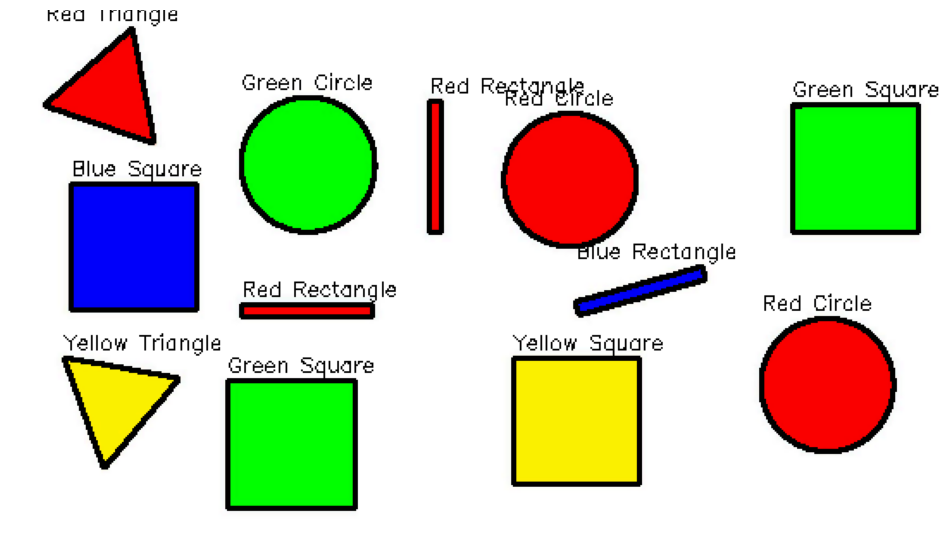

In [5]:
def detect_shapes_and_colors(image):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define color ranges
    color_ranges = {
        'Red': ([0, 100, 100], [10, 255, 255]),
        'Yellow': ([20, 100, 100], [35, 255, 255]),
        'Green': ([35, 50, 50], [85, 255, 255]),
        'Blue': ([85, 50, 50], [130, 255, 255])
    }

    # Create masks for each color
    masks = {color: cv2.inRange(hsv, np.array(lower), np.array(upper))
             for color, (lower, upper) in color_ranges.items()}

    # Add a second range for red to capture both ends of the hue spectrum
    masks['Red'] = cv2.bitwise_or(masks['Red'], cv2.inRange(hsv, np.array([170, 100, 100]), np.array([180, 255, 255])))

    # Find contours for each color mask
    contours = {color: cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
                for color, mask in masks.items()}

    for color, color_contours in contours.items():
        for cnt in color_contours:
            area = cv2.contourArea(cnt)
            if area < 100:  # Ignore very small contours
                continue

            # Approximate the contour
            epsilon = 0.04 * cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, epsilon, True)
            x, y, w, h = cv2.boundingRect(cnt)

            # Improved shape detection
            if len(approx) == 3:
                shape = "Triangle"
            elif len(approx) == 4:
                aspect_ratio = float(w) / h
                shape = "Square" if 0.95 <= aspect_ratio <= 1.05 else "Rectangle"
            else:
                # Improved circle detection
                circularity = 4 * np.pi * area / (cv2.arcLength(cnt, True) ** 2)
                if circularity > 0.8:
                    shape = "Circle"
                else:
                    # Check for thin rectangles
                    if min(w, h) / max(w, h) < 0.5:
                        shape = "Rectangle"
                    else:
                        shape = "Unknown"

            # Draw the contour and label the shape and color on the image
            cv2.drawContours(image, [cnt], 0, (0, 0, 0), 2)
            label = f"{color} {shape}"
            cv2.putText(image, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)

    return image

# Load and process the image
image = cv2.imread('/content/test.jpg')
output_image = detect_shapes_and_colors(image)

# Convert image to RGB and display
output_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(output_rgb)
plt.axis('off')
plt.show()